In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import os
from scipy import stats as scs
os.chdir('../')
from src.modeling import *
os.chdir('notebooks')

pd.options.display.max_columns = 100
pd.options.display.max_rows = 100
import warnings 
warnings.simplefilter('ignore')


# Important notes:

- N2 (number of exemptions) represents the population
- N1 represents number of households 
- A00100 represents AGI
- N00200 represents number of returns with salaries and wages
- A00200 represents the amount of salaries and wages

[source](https://www.irs.gov/statistics/soi-tax-stats-individual-income-tax-statistics-zip-code-data-soi)

From data_dictionary:

 - N02650	Number of returns with total income
 - A02650	Total income amount

## Importing the data

In [2]:
# Should be dropped when predicting number of playgrounds as Y variable ( data leakage)
columns_from_playgrounds_dataset = ['Accessible', 'Adaptive_Swing', 'School', 'Status_closed',
       'Status_open to the public', 'Status_two playgrounds', 'Status_weekdays', 
        'Status_weekends', 'Level_1.0', 'Level_2.0', 'Level_3.0', 'Level_4.0']

In [3]:
df = pd.read_csv('../data/nyc_playgrounds.csv', index_col='zipcode')
df.fillna(0, inplace=True)
df.head()

,Accessible,Adaptive_Swing,School,Status_closed,Status_open to the public,Status_two playgrounds,Status_weekdays,Status_weekends,Level_1.0,Level_2.0,Level_3.0,Level_4.0,playground_count,POPULATION,AREA,geometry,N1,mars1,MARS2,MARS4,PREP,N2,NUMDEP,TOTAL_VITA,VITA,TCE,VITA_EIC,RAL,RAC,ELDERLY,A00100,N02650,A02650,N00200,A00200,N00300,A00300,N00600,A00600,N00650,A00650,N00700,A00700,N00900,A00900,N01000,A01000,N01400,A01400,N01700,...,A07100,N07300,A07300,N07180,A07180,N07230,A07230,N07240,A07240,N07220,A07220,N07260,A07260,N09400,A09400,N85770,A85770,N85775,A85775,N09750,A09750,N10600,A10600,N59660,A59660,N59720,A59720,N11070,A11070,N10960,A10960,N11560,A11560,N06500,A06500,N10300,A10300,N85530,A85530,N85300,A85300,N11901,A11901,N11902,A11902,borough_name,Borough_M,Borough_Q,Borough_R,Borough_X
zipcode,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
10001,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,3.0,22413.0,1.779494e+07,POLYGON ((-74.00827017706987 40.75258680959698...,14520,10450,2540,1120,8790,19960,3290,350,160,190,60,40,1230,2560,2291296,14520,2323084,12080,1618969,5580,25849,4820,58288,4550,44542,3350,14915,2980,82477,4470,192534,1080,19430,1610,...,14647,2130,11613,290,185,520,585,330,59,540,521,0,0,2500,14882,160,372,200,378,470,391,13490,558829,1470,2406,1100,1937,520,611,420,377,80,75,11710,497478,12470,524842,1980,6213,1680,7081,3680,40079,9600,51137,M,1,0,0,0
10002,22.0,4.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,11.0,1.0,10.0,23.0,81305.0,2.628013e+07,"POLYGON ((-73.97441674502171 40.736424085467, ...",42180,25270,10500,5630,28170,68970,17490,1200,920,290,330,180,3550,7680,2281527,42180,2313723,35240,1802797,9370,12873,7160,35706,6740,27472,4580,8771,7690,113416,6110,103413,1690,21212,3850,...,8395,2120,2384,1190,689,1310,1349,1270,293,2770,2636,40,22,7100,18294,400,1016,490,1096,2120,1457,37750,413475,13310,25712,10900,22616,5270,6870,1290,1117,200,194,24850,331192,29030,356377,1280,2110,1070,2964,9000,35096,30040,81377,M,1,0,0,0
10003,4.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,4.0,55878.0,1.553838e+07,POLYGON ((-73.97986374206835 40.73497413255052...,28660,21830,5340,870,18300,37530,4490,260,160,100,40,0,1650,5600,6622842,28660,6720746,23400,3965359,14260,159535,13820,310557,13290,195597,8110,50692,6710,261633,12880,931151,2950,69188,3230,...,51466,6720,46054,510,311,730,889,390,76,470,463,40,89,6010,42740,280,671,380,677,700,602,26920,1670731,1240,1269,740,904,300,326,450,411,160,213,24940,1484489,26030,1566958,5110,18272,4730,30671,8100,105180,17200,133151,M,1,0,0,0
10007,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,3.0,7323.0,5.327871e+06,"POLYGON ((-74.0133873791513 40.71743717586856,...",3440,2010,1190,120,2560,5940,1460,0,0,0,0,0,130,460,3023883,3440,3048670,2870,1159584,2110,75838,2070,280063,2000,85088,1240,24035,690,61526,1960,208492,240,6952,250,...,22062,1110,20092,170,104,80,100,40,6,80,85,0,0,720,10851,0,0,30,36,40,48,3210,830886,90,125,60,92,30,39,50,40,0,0,3080,741039,3180,767641,1400,8020,1240,19184,1170,28665,1730,67189,M,1,0,0,0
10009,7.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,6.0,7.0,61455.0,1.590352e+07,POLYGON ((-73.97345725849812 40.73070754108718...,32410,23180,5060,3470,17760,45420,9120,990,800,180,320,140,3620,5930,2574118,32410,2611193,27440,2027939,9630,11140,8280,42516,7850,31583,5460,11971,6160,107092,7280,109359,2160,32684,3940,...,8142,2910,2383,770,455,1370,1575,840,163,1710,1700,30,19,5100,17238,330,700,440,804,980,730,30610,501106,4520,8898,3550,7336,1960,2303,1040,936,150,161,25470,426753,27250,450366,1650,2675,1320,4035,7040,36988,23570,66621,M,1,0,0,0


In [4]:
# NY population was estimated to be 8.615m (google). this is pretty close
print('population estimate: {}'.format(df['N2'].sum()))
print('household estimate: {}'.format(df['N1'].sum()))

population estimate: 7294130
household estimate: 4091960


In [5]:
df['playground_count'].sum()

1253.0

## Population vs. N2 count

According to [source](https://www.irs.gov/statistics/soi-tax-stats-individual-income-tax-statistics-zip-code-data-soi) the N2 count is supposed to be a close representation of the total population. The N2 column should be preferred over the POPULATION column as the Population column is from a different 2014 dataset, and the parks and tax returns data is 2016 data. It is, however a good data check


In [6]:
print('There is a {}% difference in the population counts'.format(
    round((df['POPULATION'].sum() - df['N2'].sum())
      /df['POPULATION'].sum()*100,2)))

There is a 10.37% difference in the population counts


In [7]:
df.drop('POPULATION', axis=1, inplace=True)

# Feature engineering: creating new measures

After observing the data dictionary, these are some interesting features I decided to create. Will investifate them further throughout this notebook

In [8]:
df['mean_household_agi'] = df.A00100 / df.N1
df['mean_household_income'] = df.A02650 / df.N1
df['mean_wages_per_person'] = df.A00200 / df.N00200
sqft_sqmi_conversion = 3.58701e-8
df['AREA'] *= sqft_sqmi_conversion
df['population_density'] = (df['N2']/df['AREA'])
df['household_density'] = (df['N1']/df['AREA'])

In [9]:
# These lists will be useful for quick operations later
y_cols = ['playground_count']

object_type_columns = ['borough_name', 'geometry']

# Method 1: Logical Feature Engineering

## Feature Reduction: eliminating collinear features

Using the identify_collinear function to remove collinearity from the X variables

In [10]:
# consolidates the amount and number columns for each tax code
# Ex: A00200 and N00200 become mean_00200
df = consolidate_tax_codes(df) 

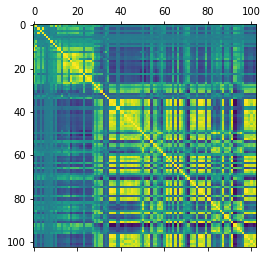

In [11]:
plt.matshow(df.corr())

#### Number of Households and Population are collinear (makes sense)
Since I am more interested in household income, I should keep N1. I created a few features using N2 and should drop those from my dataset

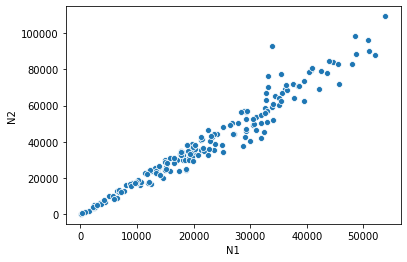

In [12]:
sns.scatterplot(df.N1, df.N2)

In [13]:
# Dropping the engineered features that incorporate N2
df.drop(['population_density', 'N2'],
        axis=1,inplace=True)

In [14]:
def check_collinear_features(df, col, threshold):
    correlations = df.corr()[col]
    return correlations[correlations > threshold]

In [15]:
check_collinear_features(df, 'mean_household_income', 0.8)

mean_household_agi       0.999993
mean_household_income    1.000000
mean_wages_per_person    0.954732
mean_02650               1.000000
mean_00200               0.954732
mean_00600               0.889495
mean_00650               0.820699
mean_00700               0.946821
mean_00900               0.891556
mean_01000               0.876152
mean_02900               0.963714
mean_04470               0.938025
mean_18425               0.976332
mean_18500               0.918155
mean_18300               0.975660
mean_20800               0.803658
mean_04800               0.996848
mean_05800               0.994897
mean_09600               0.875197
mean_07100               0.861183
mean_07300               0.824982
mean_09400               0.922296
mean_10600               0.990298
mean_06500               0.993854
mean_10300               0.994622
mean_85530               0.833496
mean_85300               0.800616
mean_11901               0.932571
mean_11902               0.913833
Name: mean_hou

Some of these may be important to drop later

I can drop both mean_household_income and mean_wages_per_person since they are both colinear with mean_household_agi, which I'm more interested in

In [16]:
df.drop(['mean_household_income', 'mean_wages_per_person'],axis=1,inplace=True)

# EDA

### Normalizing Income by borough

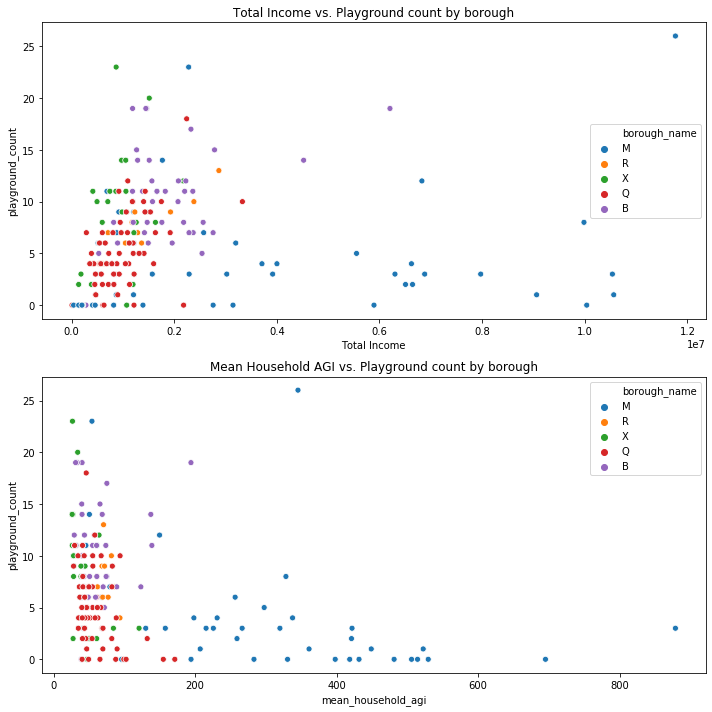

In [17]:
fig, ax = plt.subplots(2,1, figsize=(10,10))
# A00100 is total income
sns.scatterplot(df['A00100'], df.playground_count, hue=df['borough_name'], ax=ax[0])
ax[0].set_title('Total Income vs. Playground count by borough')
ax[0].set_xlabel('Total Income')
# Note mean_household_agi is a function of A00100
sns.scatterplot(df['mean_household_agi'], df.playground_count, 
              hue=df['borough_name'], ax=ax[1])
ax[1].set_title('Mean Household AGI vs. Playground count by borough')

plt.tight_layout()

It looks like theres a difference in distribution of AGI by borough. It might be useful to normalize the A00100 with the mean A00100 per borough and normalize the mean household AGI with the mean household AGI of each borough

In [18]:
def create_borough_mean_AGI(df):
    borough_mean_agi = (df.groupby('borough_name').mean()['A00100']).reset_index()
    borough_mean_agi.columns = ['borough_name', 'borough_mean_agi']
    df2 = pd.merge(df.reset_index(), borough_mean_agi, on='borough_name')
    return df2.set_index('zipcode')

def create_borough_mean_household_AGI(df):
    borough_mean_agi = (df.groupby('borough_name').sum()['A00100']\
        / df.groupby('borough_name').sum()['N1']).reset_index()
    borough_mean_agi.columns = ['borough_name', 'borough_mean_household_agi']
    df2 = pd.merge(df.reset_index(), borough_mean_agi, on='borough_name')
    return df2.set_index('zipcode')



In [19]:
df = create_borough_mean_household_AGI(df)
df = create_borough_mean_AGI(df)

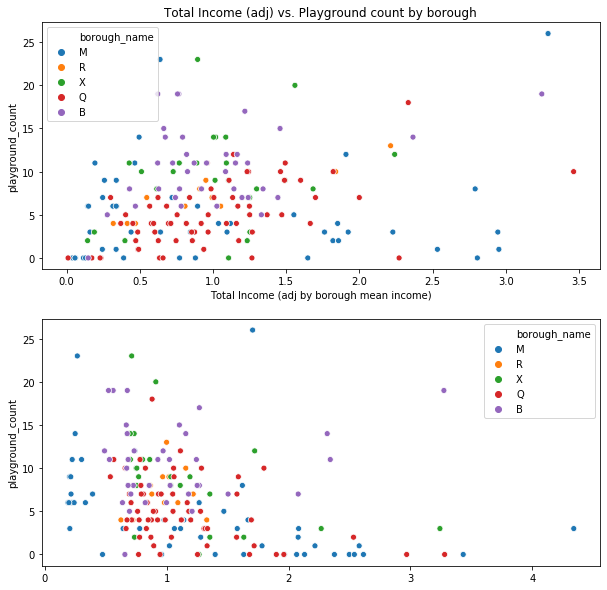

In [20]:
fig, ax = plt.subplots(2,1, figsize=(10,10))
sns.scatterplot(df.A00100/df.borough_mean_agi, 
             df.playground_count, hue=df['borough_name'], ax=ax[0])

ax[0].set_title('Total Income (adj) vs. Playground count by borough')
ax[0].set_xlabel('Total Income (adj by borough mean income)')


sns.scatterplot(df.mean_household_agi/df.borough_mean_household_agi, 
             df.playground_count, hue=df['borough_name'], ax=ax[1])

In [21]:
df['normalized_A00100'] = df.A00100/df.borough_mean_agi
df['normalized_mean_household_agi'] = df.mean_household_agi/df.borough_mean_household_agi

### Household Density and area

Text(0.5, 1.0, 'Area log adjusted')

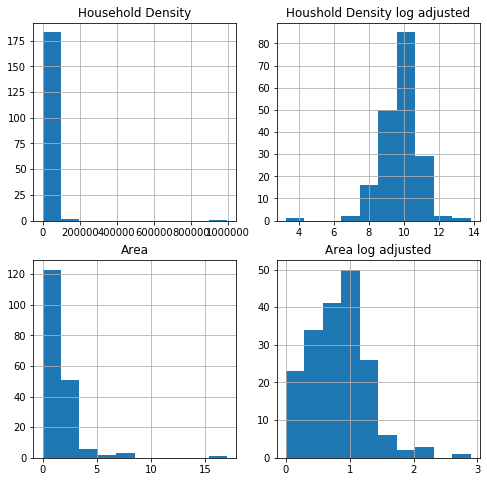

In [22]:
fig,ax = plt.subplots(2,2, figsize=(8,8))

df['household_density'].hist(ax=ax[0,0])
ax[0,0].set_title('Household Density')
np.log(df['household_density']+1).hist(ax=ax[0,1])
ax[0,1].set_title('Houshold Density log adjusted')

df['AREA'].hist(ax=ax[1,0])
ax[1,0].set_title('Area')
np.log(df['AREA']+1).hist(ax=ax[1,1])
ax[1,1].set_title('Area log adjusted')

These log adjustments seem to be helpful to minimize the influence of outlier

In [23]:
def plot_hist_vs_loghist(df, col):
    fig,ax = plt.subplots(1,2,figsize=(8,2))
    df[col].hist(ax=ax[0])
    ax[0].set_title(col)
    np.log(df[col]+1).hist(ax=ax[1])
    ax[1].set_title(col + ' log adjusted')
    plt.show()

## Exploring the y variables, measures of 'Playground Availability'

In [24]:
y_cols

['playground_count']

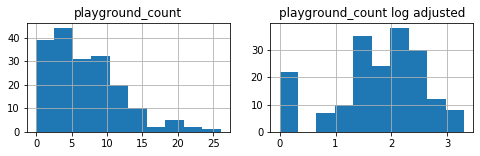

In [25]:
plot_hist_vs_loghist(df, 'playground_count')

# Exploring interesting variables

Text(0, 0.5, 'Playground Count')

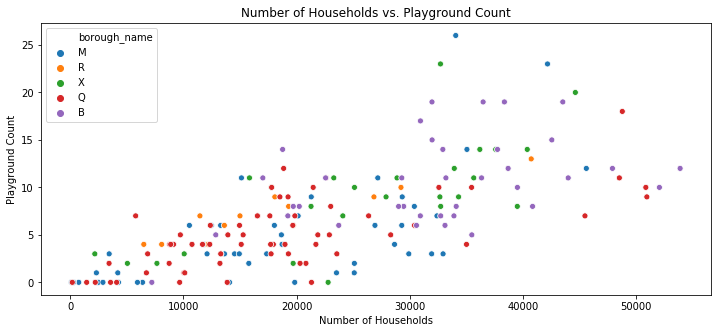

In [26]:
fig, ax = plt.subplots(1,1, figsize=(12,5))
sns.scatterplot(df.N1, df.playground_count, 
              hue=df['borough_name'], ax=ax)
plt.title('Number of Households vs. Playground Count')
plt.xlabel('Number of Households')
plt.ylabel('Playground Count')

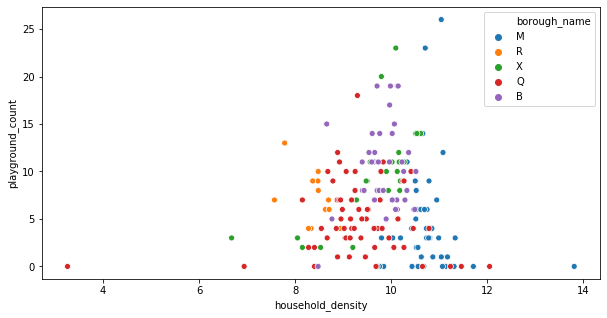

In [27]:
fig, ax = plt.subplots(figsize=(10,5))
sns.scatterplot(np.log(df.household_density+1), df.playground_count,
            hue=df['borough_name'], ax=ax)

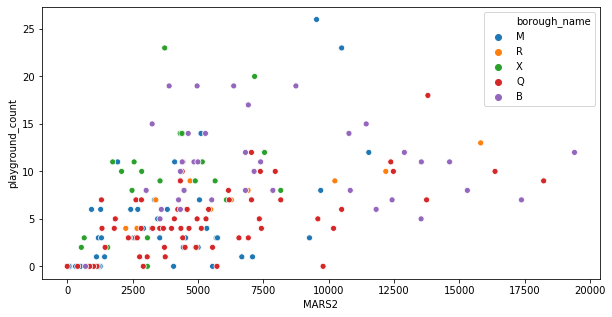

In [28]:
fig, ax = plt.subplots(figsize=(10,5))
sns.scatterplot(df.MARS2, df.playground_count,
            hue=df['borough_name'], ax=ax)

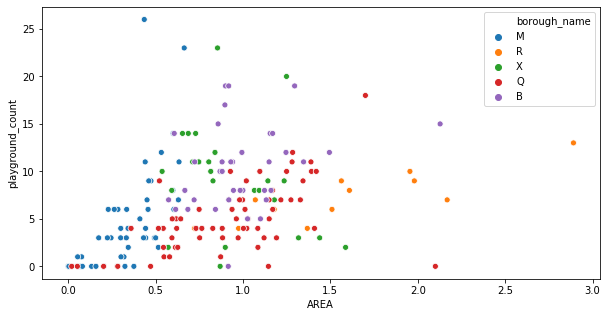

In [29]:
fig, ax = plt.subplots(figsize=(10,5))
sns.scatterplot(np.log(df.AREA+1), df.playground_count,
            hue=df['borough_name'], ax=ax)

# More Feature selection

Due to the time constraint, I am going to use a __Backward Selection__ a Recursive Feature Elimination strategy. This process can introduce bias, however it is commonly used in practice

In [93]:
y = df['playground_count']
X = df.drop(['playground_count', 'geometry', 'borough_name'] + columns_from_playgrounds_dataset,axis=1)

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns)

In [94]:
res, log_features = RFE(X_train,y_train, log_y=True)
regression_columns = [col for col in list(res.pvalues.index) if col != 'const']
res.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.885
Model:                            OLS   Adj. R-squared:                  0.853
Method:                 Least Squares   F-statistic:                     27.70
Date:                Tue, 10 Dec 2019   Prob (F-statistic):           1.94e-40
Time:                        18:42:22   Log-Likelihood:                -29.423
No. Observations:                 148   AIC:                             124.8
Df Residuals:                     115   BIC:                             223.8
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  1.7112      0.028     62.166      0.000       1.657       1.766
MARS4                 -1.1125      0.209     -5.313      0.000      -1.527      -0.698
PREP                  -0.3505      0.118     -2.963      0.004      -0.585      -0.116
NUMDEP                 1.5152      0.214      7.095      0.000       1.092       1.938
TCE                   -0.1132      0.044     -2.582      0.011      -0.200      -0.026
RAC                    0.3250      0.067      4.880      0.000       0.193       0.457
ELDERLY                0.3068      0.093      3.291      0.001       0.122       0.491
A00100                 0.8632      0.125      6.916      0.000       0.616       1.110
SCHF                   0.1962      0.046      4.293      0.000       0.106       0.287
Borough_Q              0.3015      0.070      4.325      0.000       0.163       0.440
Borough_R              0.1811      0.035      5.120      0.000       0.111       0.251
Borough_X              0.1578      0.053      2.994      0.003       0.053       0.262
mean_household_agi    76.3199     20.818      3.666      0.000      35.083     117.556
mean_02650           -80.7574     21.147     -3.819      0.000    -122.646     -38.869
mean_00600             0.9494      0.132      7.172      0.000       0.687       1.212
mean_02300             0.2498      0.102      2.443      0.016       0.047       0.452
mean_03150             0.2552      0.087      2.920      0.004       0.082       0.428
mean_17000            -0.2619      0.077     -3.384      0.001      -0.415      -0.109
mean_18425             2.5125      0.765      3.283      0.001       0.997       4.028
mean_18500            -1.5849      0.183     -8.646      0.000      -1.948      -1.222
mean_18300            -3.4630      0.937     -3.697      0.000      -5.319      -1.608
mean_19300             0.1653      0.063      2.641      0.009       0.041       0.289
mean_19500             0.0962      0.044      2.163      0.033       0.008       0.184
mean_19550            -0.1712      0.056     -3.074      0.003      -0.281      -0.061
mean_07300             0.3289      0.093      3.535      0.001       0.145       0.513
mean_07220            -0.6250      0.122     -5.117      0.000      -0.867      -0.383
mean_07260            -0.2208      0.048     -4.613      0.000      -0.316      -0.126
mean_09400            -0.3862      0.172     -2.245      0.027      -0.727      -0.045
mean_85770             0.3863      0.114      3.388      0.001       0.160       0.612
mean_85775            -0.2304      0.106     -2.170      0.032      -0.441      -0.020
mean_10300             3.8961      0.539      7.228      0.000       2.828       4.964
mean_11901             1.4648      0.201      7.273      0.000       1.066       1.864
normalized_A00100     -0.2408      0.1

# Making predictions on the holdout set

In [77]:
ypreds = res.predict(sm.add_constant(X_test[regression_columns]),
                     transform=True)

def rmse(y, y_pred):
    return np.sqrt(np.mean(np.square(y - y_pred)))

def MAE(y_pred, y_test):
    return np.mean(np.abs(y_test-y_pred))

MAE(y_test, np.log(ypreds+0.0001))


5.772317227371445

Certainly not the best approach, but not the worst either. Due to time constraints, I did not center or scale this data which doesn't help. Could really benefit from making another model that classifies a region as having 0 parks or greater than zero parks

# Regularized Regression

# Testing out of box Ridge and Lasso Regression models


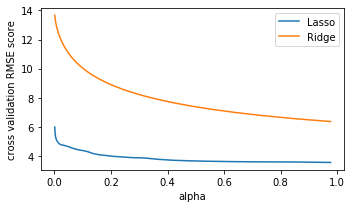

In [78]:
alphas = np.logspace(-3, -0.01, 50)
plt.figure(figsize=(5, 3))


for Model in [Lasso, Ridge]:
    scores = [np.sqrt(cross_val_score(Model(alpha), X_train, y_train, cv=10, 
                scoring = 'neg_mean_squared_error')*-1).mean() for alpha in alphas]
    plt.plot(alphas, scores, label=Model.__name__)

plt.legend()
plt.xlabel('alpha')
plt.ylabel('cross validation RMSE score')
plt.tight_layout()
plt.show()

Not the worst out of box model scores. It makes sense that the lasso is outperforming the ridge regression since there are so many features. The lasso model can set the coefficients of some of these redundant features to zero.

### Scoring Ridge Regression

In [85]:
from sklearn.pipeline import make_pipeline
clf = make_pipeline(StandardScaler(), Ridge(1))
cv_score = (cross_val_score(clf, X_train, y_train, cv=10, scoring = 'neg_mean_absolute_error')*-1).mean()
print('Cross Val MAE', round(cv_score,2))


clf.fit(X_train, y_train)
print('Ridge regression MAE on test set: {}'.format(
    MAE(clf.predict(X_test),y_test)))

print('Ridge regression R^2 on test set: {}'.format(
    clf.score(X_test,y_test)))

Cross Val MAE 3.54
Ridge regression MAE on test set: 2.875643616429624
Ridge regression R^2 on test set: 0.26422514092070615


### Scoring Lasso Regression

In [95]:
from sklearn.pipeline import make_pipeline
lasso_clf = make_pipeline(StandardScaler(), Lasso(0.6))
lasso_cv_score = (cross_val_score(lasso_clf, X_train, y_train, 
            cv=10, scoring = 'neg_mean_absolute_error')*-1).mean()
print('Cross Val MAE', round(lasso_cv_score,2))


lasso_clf.fit(X_train, y_train)

print('Lasso regression MAE on test set: {}'.format(
    MAE(lasso_clf.predict(X_test),y_test)))

print('Lasso regression R^2 on test set: {}'.format(
    lasso_clf.score(X_test,y_test)))

Cross Val MAE 2.52
Lasso regression MAE on test set: 2.2428679464263275
Lasso regression R^2 on test set: 0.576301194476609


The lasso looks like an excellent model. The most important features determined by the lasso are below, however this certainly could have been skewed by multicollinearity

In [96]:
significant_features = np.nonzero(lasso_clf['lasso'].coef_)[0]

In [97]:
coefs = lasso_clf['lasso'].coef_[significant_features]

In [98]:
features = X_train.iloc[:,significant_features]
features

,AREA,N1,mars1,RAL,mean_59720
zipcode,,,,,
10003,0.557363,28660,21830,0,1.221622
11354,2.223413,30420,16210,40,1.819068
11219,1.506642,33910,12300,30,3.206143
10458,1.290205,34320,17370,570,2.598022
11426,1.779486,9130,4250,0,1.979167
...,...,...,...,...,...
10023,0.545682,34070,21740,20,1.703774
10471,3.215805,10070,5330,20,1.963077
11233,1.358461,31980,17160,560,2.366551


In [99]:
pd.DataFrame(zip(features.columns, coefs), columns = ['Features', 'Lasso Coefs']).set_index('Features')

,Lasso Coefs
Features,
AREA,0.105677
N1,1.710514
mars1,0.388622
RAL,1.461875
mean_59720,0.384135


 - N1: number of returns
 - AREA: area of zipcode
 - MARS1: Number of Single Returns 
 - RAL: Number of refund anticipation loan returns
 - 59720: returns with excess earned income credit

# Next steps:
 - Visualize the individual relations of these features
 - Reduce multicollinearity
 - Create a second model to predict if zipcodes have greater than zero parks
 - Test out sklearns n-best features package
 - Identify the zipcodes that _should_ have more playgrounds, but do not. These could be areas that are in need of playgrounds!